In [1]:
import torch
import torch.nn as nn
import torchvision

from torchvision import transforms

In [2]:
image_path = "../data"

In [3]:
def get_smile(attr):
    return attr[18]

In [4]:
transform_train = transforms.Compose(
    [
        transforms.RandomCrop([178, 178]),
        transforms.RandomHorizontalFlip(),
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
    ]
)

In [5]:
transform = transforms.Compose(
    [
        transforms.CenterCrop([178, 178]),
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
    ]
)

In [6]:
from torch.utils.data import DataLoader

In [7]:
celeba_train_dataset = torchvision.datasets.CelebA(
    image_path,
    split="train",
    target_type="attr",
    download=False,
    transform=transform_train,
    target_transform=get_smile,
)

celeba_valid_dataset = torchvision.datasets.CelebA(
    image_path,
    split="valid",
    target_type="attr",
    download=False,
    transform=transform,
    target_transform=get_smile,
)

celeba_test_dataset = torchvision.datasets.CelebA(
    image_path,
    split="test",
    target_type="attr",
    download=False,
    transform=transform,
    target_transform=get_smile,
)

In [8]:
from torch.utils.data import Subset

celeba_train_dataset = Subset(celeba_train_dataset, torch.arange(50000))
celeba_valid_dataset = Subset(celeba_valid_dataset, torch.arange(2000))

In [9]:
batch_size = 32
device = torch.device("mps")
torch.manual_seed(1)

train_dl = DataLoader(
    celeba_train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

valid_dl = DataLoader(
    celeba_valid_dataset,
    batch_size=batch_size,
    shuffle=False,
)

test_dl = DataLoader(
    celeba_test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [10]:
model = nn.Sequential()

model.add_module(
    "conv1", nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
)
model.add_module("relu1", nn.ReLU())
model.add_module("pool1", nn.MaxPool2d(kernel_size=2))
model.add_module("dropout1", nn.Dropout(p=0.5))

model.add_module(
    "conv2", nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
)
model.add_module("relu2", nn.ReLU())
model.add_module("pool2", nn.MaxPool2d(kernel_size=2))
model.add_module("dropout2", nn.Dropout(p=0.5))

model.add_module(
    "conv3", nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
)
model.add_module("relu3", nn.ReLU())
model.add_module("pool3", nn.MaxPool2d(kernel_size=2))

model.add_module(
    "conv4", nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
)
model.add_module("relu4", nn.ReLU())
model.add_module("pool4", nn.AvgPool2d(kernel_size=8))
model.add_module("flatten", nn.Flatten())
model.add_module("fc", nn.Linear(256, 1))
model.add_module("sigmoid", nn.Sigmoid())

In [11]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = ((pred >= 0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = ((pred >= 0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()

            loss_hist_valid[epoch] /= len(valid_dl.dataset)
            accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(
            f"Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}"
        )

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [13]:
torch.manual_seed(1)
num_epochs = 50
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.6846 val_accuracy: 0.7495
Epoch 2 accuracy: 0.7484 val_accuracy: 0.7735
Epoch 3 accuracy: 0.7748 val_accuracy: 0.8215
Epoch 4 accuracy: 0.8201 val_accuracy: 0.8480
Epoch 5 accuracy: 0.8396 val_accuracy: 0.8525
Epoch 6 accuracy: 0.8548 val_accuracy: 0.8715
Epoch 7 accuracy: 0.8577 val_accuracy: 0.8815
Epoch 8 accuracy: 0.8638 val_accuracy: 0.8795
Epoch 9 accuracy: 0.8671 val_accuracy: 0.8860
Epoch 10 accuracy: 0.8687 val_accuracy: 0.8905
Epoch 11 accuracy: 0.8725 val_accuracy: 0.8920
Epoch 12 accuracy: 0.8717 val_accuracy: 0.8960
Epoch 13 accuracy: 0.8743 val_accuracy: 0.8925
Epoch 14 accuracy: 0.8767 val_accuracy: 0.8950
Epoch 15 accuracy: 0.8778 val_accuracy: 0.8985
Epoch 16 accuracy: 0.8788 val_accuracy: 0.8980
Epoch 17 accuracy: 0.8818 val_accuracy: 0.9010
Epoch 18 accuracy: 0.8811 val_accuracy: 0.9030
Epoch 19 accuracy: 0.8814 val_accuracy: 0.8995
Epoch 20 accuracy: 0.8845 val_accuracy: 0.8940
Epoch 21 accuracy: 0.8843 val_accuracy: 0.8950
Epoch 22 accuracy: 0.8

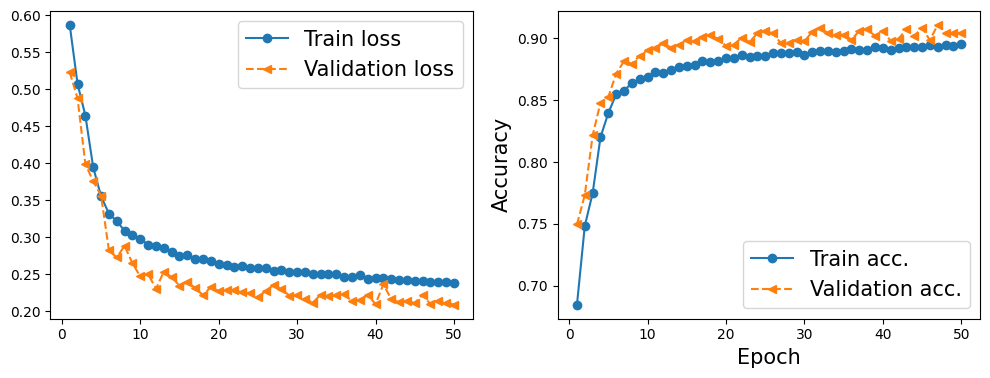

In [14]:
import numpy as np
import matplotlib.pyplot as plt

x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], "-o", label="Train loss")
ax.plot(x_arr, hist[1], "--<", label="Validation loss")
ax.legend(fontsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], "-o", label="Train acc.")
ax.plot(x_arr, hist[3], "--<", label="Validation acc.")
ax.legend(fontsize=15)
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("Accuracy", size=15)

plt.show()

In [15]:
# Evaluate model on test dataset
accuracy_test = 0
model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        pred = model(x_batch)[:, 0]
        is_correct = ((pred >= 0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum()

accuracy_test /= len(test_dl.dataset)
print(f"Test accuracy: {accuracy_test:.4f}")

# Next we'll visualize predictions on test examples
# We'll take 10 examples from test_dl and compute smile probabilities
# The examples will be shown with ground truth labels and predicted probabilities

Test accuracy: 0.8917


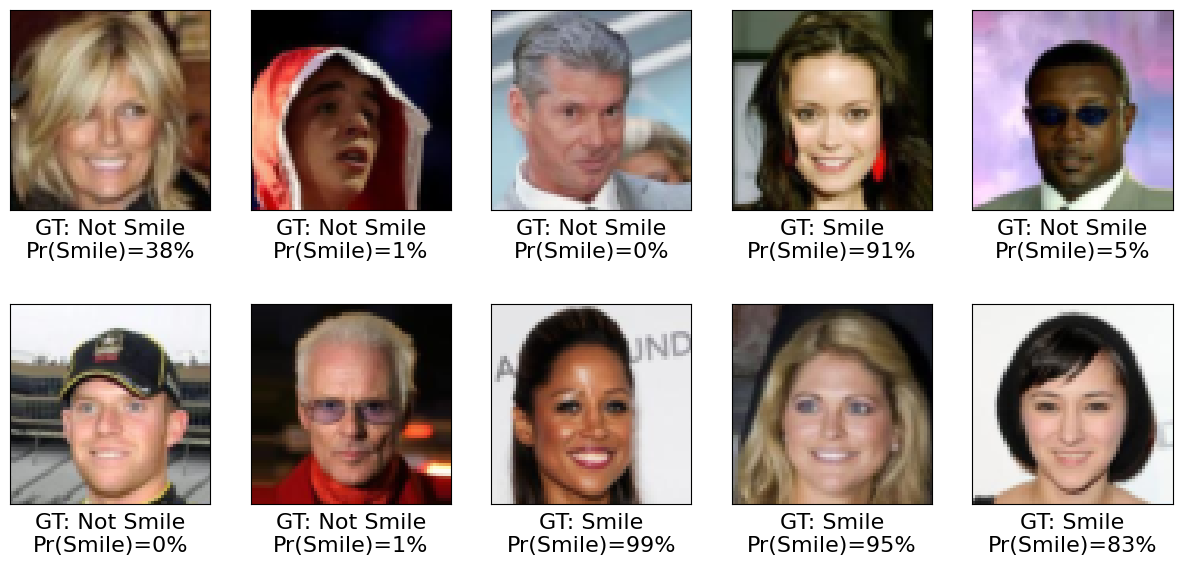

In [16]:
pred = model(x_batch)[:, 0] * 100
fig = plt.figure(figsize=(15, 7))

for j in range(10, 20):
    ax = fig.add_subplot(2, 5, j - 10 + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(x_batch[j].permute(1, 2, 0))

    if y_batch[j] == 1:
        label = "Smile"
    else:
        label = "Not Smile"

    ax.text(
        0.5,
        -0.15,
        f"GT: {label:s}\nPr(Smile)={pred[j]:.0f}%",
        size=16,
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
    )

plt.show()

In [18]:
# Calculate AUC-ROC score manually
import numpy as np

# Get predictions for full test set
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        pred = model(x_batch)[:, 0]
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Sort predictions and corresponding labels
sorted_indices = np.argsort(all_preds)[::-1]
sorted_labels = all_labels[sorted_indices]

# Calculate TPR and FPR at different thresholds
n_pos = np.sum(all_labels == 1)
n_neg = len(all_labels) - n_pos
tpr = np.cumsum(sorted_labels) / n_pos
fpr = np.cumsum(1 - sorted_labels) / n_neg

# Calculate AUC using trapezoidal rule
auc_score = np.trapz(y=tpr, x=fpr)
print(f"AUC-ROC Score: {auc_score:.4f}")

AUC-ROC Score: 0.9649


/var/folders/cp/y605gsj11zd0js5ky7y01ssr0000gn/T/ipykernel_50837/690984118.py:29: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_score = np.trapz(y=tpr, x=fpr)
